# An introduction of RDKit utilities
RDKit is an open-source cheminformatics software that allows users to manipulate and analyze chemical structures, molecules, and molecualr data. It is widely used in drug discovery and materials science for tasks such as molecular modeling, property prediction, and virtual screening. Adapted from a part of [demonstration](https://www.rdkit.org/docs/GettingStartedInPython.html#) in the RDKit documentation, this notebooks demonstrates some common utilities of RDKit, with additional explanations and examples. The very detailed documentation can be found at https://www.rdkit.org/docs/index.html, and the project is hosted on GitHub at https://github.com/rdkit/rdkit. Note that in addition to some less relevant examples, the following sections in the documentation are not covered in this notebook:
- Chemical reactions
- R-group decomposition
- Non-chemical functionality
- Miscellaneous Tips and Hints
- List of available descriptors
- List of available 3D descriptors
- List of available fingerprints
- Feature definitions used in the Morgan fingerprints

Here is a table of content of this notebook:
- [1. Reading, drawing, and writing molecules](#1.-Reading,-drawing,-and-writing-molecules)
- [2. Working with molecules](#2.-Working-with-molecules)
- [3. Substructure searching](#3.-Substructure-searching)
- [4. Chemical transformations](#4.-Chemical-transformations)
- [5. Maximum Common Substructure](#5.-Maximum-Common-Substructure)
- [6. Fingerprinting and molecular similarity](#6.-Fingerprinting-and-molecular-similarity)
- [7. Descriptor calculation](#7.-Descriptor-calculation)
- [8. Chemical features and pharmacophores](#8.-Chemical-features-and-pharmacophores)
- [9. Molecular fragments](#9.-Molecular-fragments)
- [10. Getting help](#12.-Getting-help)
- [11. Advanced topics/warnings](#13.-Advanced-topics/warnings)
- [12. Filtering molecular datasets](#14.-Filtering-molecular-datasets)

## 1. Reading, drawing, and writing molecules
### 1.1. Some terminologies
- **SMILES**: Simplified Molecular Input Line Entry System is a line notation for describing the structure of chemical species using short ASCII strings. It is a popular way to represent chemical structures in a human-readable format. For more information, please see https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system
- **SMARTS**: SMILES arbitrary target specification (SMARTS) is a language for specifying substructural patterns in molecules. The SMARTS line notation is expressive and allows extremely precise and transparent substructural specification and atom typing. For information, see https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html
- **InChI**: The International Chemical Identifier (InChI) is a textual identifier for chemical substances, designed to provide a standard way to encode molecular information and to facilitate the search for such information in databases and on the web. For more information, see https://en.wikipedia.org/wiki/International_Chemical_Identifier

### 1.2. Reading single molecules

Individual molecules can be constructed using a variety of approaches. Note that when construing a molecule from a file, hydrogen atoms are all removed by default. This can be changed by setting the `removeHs` parameter to `False`.

In [1]:
from rdkit import Chem

# 1. Create a molecule from a SMILES string
mol_1 = Chem.MolFromSmiles('CCO')

# 2. Create a molecule from a MOL file
mol_2 = Chem.MolFromMolFile('../data/alanine.mol')

# 3. Create a molecule from a SDF file
mol_3 = Chem.SDMolSupplier('../data/alanine.sdf')[0]  # there is only one molecule in the file

# 4. Create a molecule from a PDB file
mol_4 = Chem.MolFromPDBFile('../data/analnine_dipeptide.pdb')

# 5. Create a molecule from an InChI string
mol_5 = Chem.MolFromInchi('InChI=1S/C6H6/c1-2-4-6-5-3-1/h1-6H')

Alternatively, a mol file can also be read using the `Chem.MolFromMolBlock` function.

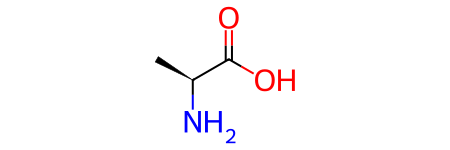

In [2]:
stringWithMolData=open('../data/alanine.mol','r').read()  # This also works for SDF files
Chem.MolFromMolBlock(stringWithMolData)

A full list of `MolFrom*` functions for constructing a molecule using RDKit is as follows. More information can be found in the [documentation](https://www.rdkit.org/docs/source/rdkit.Chem.html).
- `MolFromFASTA()`
- `MolFromHELM()`
- `MolFromMol2Block()`
- `MolFromMol2File()`
- `MolFromMolBlock()`
- `MolFromMolFile()`
- `MolFromMrvBlock()`
- `MolFromMrvFile()`
- `MolFromPDBBlock()`
- `MolFromPDBFile()`
- `MolFromPNGFile()`
- `MolFromPNGString()`
- `MolFromRDKitSVG()`
- `MolFromSequence()`
- `MolFromSmarts()`
- `MolFromSmiles()`
- `MolFromTPLBlock()`
- `MolFromTPLFile()`
- `MolFromXYZBlock()`
- `MolFromXYZFile()`

All of these functions return a `rdkit.Chem.rd.chem.Mol` object on success, or `None` on failure. RDKit will attempt to provide a useful error message if the input is invalid. See the example below:


In [3]:
m = Chem.MolFromSmiles('CO(C)C')

[02:23:17] Explicit valence for atom # 1 O, 3, is greater than permitted


In [4]:
m is None

True

Notably, an `rdkit.Chem.rdchem.Mol` object can be displayed graphically using `rdkit.Chem.Draw.MolToImage()`:

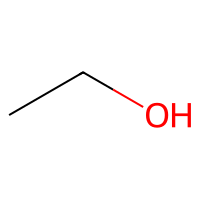

In [5]:
from rdkit.Chem import Draw
Draw.MolToImage(mol_1, size=(200, 200))

To display multiple images, one can use `rdkit.Chem.Draw.MolsToGridImage()`:

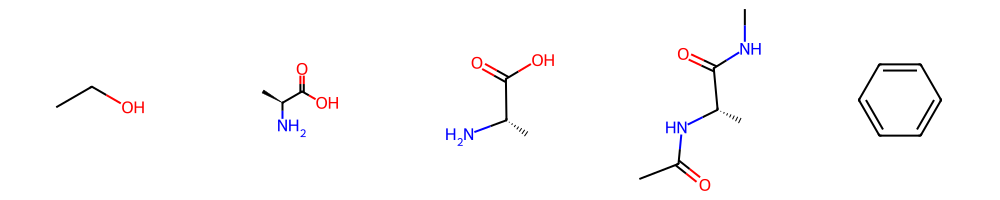

In [6]:
Draw.MolsToGridImage([mol_1, mol_2, mol_3, mol_4, mol_5], molsPerRow=5, subImgSize=(200, 200))

### 1.2. Reading sets of molecules
Groups of molecules are read using a Supplier (for example, an `rdkit.Chem.rdmolfiles.SDMolSupplier` or a `rdkit.Chem.rdmolfiles.SmilesMolSupplier`):

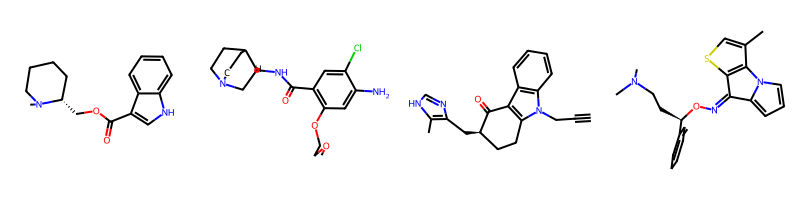

In [7]:
suppl = Chem.SDMolSupplier('../data/5ht3ligs.sdf')
Draw.MolsToGridImage([x for x in suppl if x is not None], molsPerRow=len(suppl), subImgSize=(200, 200))

Two good practices when working with Suppliers are to use a context manager and to test each molecule to see if it was correctly read before working with it:

In [8]:
with Chem.SDMolSupplier('../data/5ht3ligs.sdf') as suppl:
  for mol in suppl:
    if mol is None: 
        continue
    print(mol.GetNumAtoms())  # Print the number of atoms in each molecule. We'll explore more methods later.

20
24
24
26


An alternate type of Supplier, the `rdkit.Chem.rdmolfiles.ForwardSDMolSupplier` can be used to read from file-like objects. Note, however, that `ForwardSDMolSupplier` does not support indexing.

In [9]:
inf = open('../data/5ht3ligs.sdf','rb')
with Chem.ForwardSDMolSupplier(inf) as fsuppl:
  for mol in fsuppl:
    if mol is None: 
        continue
    print(mol.GetNumAtoms())

20
24
24
26


This means that they can be used to read from compressed files:

In [10]:
import gzip
inf = gzip.open('../data/actives_5ht3.sdf.gz')
with Chem.ForwardSDMolSupplier(inf) as gzsuppl:
   ms = [x for x in gzsuppl if x is not None]
len(ms)

180

For reading Smiles or SDF files with large number of records concurrently, `MultithreadedMolSuppliers` can be used like this:

In [11]:
i = 0
with Chem.MultithreadedSDMolSupplier('../data/5ht3ligs.sdf') as sdSupl:
  for mol in sdSupl:
    if mol is not None:
      i += 1

print(i)

4


By default a single reader thread is used to extract records from the file and a single writer thread is used to process them. Note that due to multithreading the output may not be in the expected order. Furthermore, the `MultithreadedSmilesMolSupplier` and the `MultithreadedSDMolSupplier` do not support indexing.

### 1.3. Writing molecules
Single molecules can be converted to text using several functions present in the `rdkit.Chem module`. For example, for a SMILES string:

In [12]:
m = Chem.MolFromMolFile('../data/chiral.mol')
Chem.MolToSmiles(m)

'C[C@H](O)c1ccccc1'

Notably, in `'C[C@H](O)c1ccccc1'`, `[C@H]` represents a chiral center, where `@` indicates the specific stereochemistry (chirality) of the atom. Using `Chem.MolToSmiles`, we can choose to include or exclude stereochemistry information by setting the `isomericSmiles` parameter to `True` or `False`, respectively.

In [13]:
print(Chem.MolToSmiles(m, isomericSmiles=True))
print(Chem.MolToSmiles(m, isomericSmiles=False))

C[C@H](O)c1ccccc1
CC(O)c1ccccc1


Note that the SMILES provided is canonical, so the output should be the same no matter how a particular molecule is input:

In [14]:
print(Chem.MolToSmiles(Chem.MolFromSmiles('C1=CC=CN=C1')))
print(Chem.MolToSmiles(Chem.MolFromSmiles('c1cccnc1')))
print(Chem.MolToSmiles(Chem.MolFromSmiles('n1ccccc1')))

c1ccncc1
c1ccncc1
c1ccncc1


MDL Mol blocks are also available:

In [15]:
m2 = Chem.MolFromSmiles('C1CCC1')
print(Chem.MolToMolBlock(m2))    


     RDKit          2D

  4  4  0  0  0  0  0  0  0  0999 V2000
    1.0607    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0000   -1.0607    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.0607    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    1.0607    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  2  3  1  0
  3  4  1  0
  4  1  1  0
M  END



To include names in the mol blocks, set the molecule’s “_Name” property:

In [16]:
m2.SetProp("_Name","cyclobutane")
print(Chem.MolToMolBlock(m2))    

cyclobutane
     RDKit          2D

  4  4  0  0  0  0  0  0  0  0999 V2000
    1.0607    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0000   -1.0607    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.0607    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    1.0607    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  2  3  1  0
  3  4  1  0
  4  1  1  0
M  END



In order for atom or bond stereochemistry to be recognised correctly by most software, it’s essential that the mol block have atomic coordinates. It’s also convenient for many reasons, such as drawing the molecules. Generating a mol block for a molecule that does not have coordinates will, by default, automatically cause coordinates to be generated. These are not, however, stored with the molecule. Coordinates can be generated and stored with the molecule using functionality in the `rdkit.Chem.AllChem` module.

**Supplementary note**: Chem vs AllChem

The majority of “basic” chemical functionality (e.g. reading/writing molecules, substructure searching, molecular cleanup, etc.) is in the `rdkit.Chem` module. More advanced, or less frequently used, functionality is in `rdkit.Chem.AllChem`. The distinction has been made to speed startup and lower import times; there’s no sense in loading the 2D->3D library and force field implementation if one is only interested in reading and writing a couple of molecules. 

In [17]:
from rdkit.Chem import AllChem
AllChem.Compute2DCoords(m2)
print(Chem.MolToMolBlock(m2))     

cyclobutane
     RDKit          2D

  4  4  0  0  0  0  0  0  0  0999 V2000
    1.0607   -0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.0000   -1.0607    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.0607    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0000    1.0607    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  2  3  1  0
  3  4  1  0
  4  1  1  0
M  END



Or you can add 3D coordinates by embedding the molecule (this uses the ETKDG method, which is described in more detail below). Note that we add Hs to the molecule before generating the conformer. This is essential to get good structures:

In [18]:
m3 = Chem.AddHs(m2)
params = AllChem.ETKDGv3()
params.randomSeed = 0xf00d # optional random seed for reproducibility
AllChem.EmbedMolecule(m3, params)
print(Chem.MolToMolBlock(m3))    

cyclobutane
     RDKit          3D

 12 12  0  0  0  0  0  0  0  0999 V2000
    1.0256    0.2491   -0.0964 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.2041    0.9236    0.4320 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.0435   -0.2466   -0.0266 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.2104   -0.9922   -0.3417 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.4182    0.7667   -0.9782 H   0  0  0  0  0  0  0  0  0  0  0  0
    1.8181    0.1486    0.6820 H   0  0  0  0  0  0  0  0  0  0  0  0
   -0.1697    1.0826    1.5236 H   0  0  0  0  0  0  0  0  0  0  0  0
   -0.5336    1.8391   -0.1051 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.6809   -0.0600   -0.8987 H   0  0  0  0  0  0  0  0  0  0  0  0
   -1.6501   -0.6194    0.8220 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.4659   -1.7768    0.3858 H   0  0  0  0  0  0  0  0  0  0  0  0
    0.3439   -1.3147   -1.3988 H   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  2  3  1  0
  3  4  1  0
  4  1  1  0
  1  5  1  0
  1  6  1  0
  2  7

If we don’t want the Hs in our later analysis, they are easy to remove:

In [19]:
m3 = Chem.RemoveHs(m3)
print(Chem.MolToMolBlock(m3))    

cyclobutane
     RDKit          3D

  4  4  0  0  0  0  0  0  0  0999 V2000
    1.0256    0.2491   -0.0964 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.2041    0.9236    0.4320 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.0435   -0.2466   -0.0266 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.2104   -0.9922   -0.3417 C   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  2  3  1  0
  3  4  1  0
  4  1  1  0
M  END



If you’d like to write the molecule to a file, simply use Python file objects:

In [20]:
print(Chem.MolToMolBlock(m2),file=open('../data/foo.mol','w+'))

# Here we remove the file just to not leave it around
import os
os.remove('../data/foo.mol')

### 1.4. Writing sets of molecules
Multiple molecules can be written to a file using an `rdkit.Chem.rdmolfiles.SDWriter` object. Note that an SDWriter can also be initialized using a file-like object (see the documentation for more information). Other available Writers include the `rdkit.Chem.rdmolfiles.SmilesWriter` and the `rdkit.Chem.rdmolfiles.TDTWriter`.

In [21]:
mols = [Chem.MolFromSmiles('C[C@H](O)c1ccccc1'), Chem.MolFromSmiles('C[C@@H](O)c1ccccc1')]
with Chem.SDWriter('../data/foo.sdf') as w:
  for m in mols:
    w.write(m)

os.remove('../data/foo.sdf')

## 2. Working with molecules

### 2.1. Looping over atoms and bonds
Once you have a molecule, it’s easy to loop over its atoms and bonds:

In [27]:
m = Chem.MolFromSmiles('C1OC1')
for atom in m.GetAtoms():
  print(atom.GetAtomicNum())
print(m.GetBonds()[0].GetBondType())

6
8
6
SINGLE


You can also request individual bonds or atoms:

In [28]:
print(m.GetAtomWithIdx(0).GetSymbol())
print(m.GetAtomWithIdx(0).GetExplicitValence())
print(m.GetBondWithIdx(0).GetBeginAtomIdx())
print(m.GetBondWithIdx(0).GetEndAtomIdx())
print(m.GetBondBetweenAtoms(0,1).GetBondType())

C
2
0
1
SINGLE


Atoms keep track of their neighbors:

In [29]:
atom = m.GetAtomWithIdx(0)
print([x.GetAtomicNum() for x in atom.GetNeighbors()])
print(len(atom.GetNeighbors()[-1].GetBonds()))

[8, 6]
2


### 2.2. Ring information
Atoms and bonds both carry information about the molecule’s rings:

In [31]:
m = Chem.MolFromSmiles('OC1C2C1CC2')
print(m.GetAtomWithIdx(0).IsInRing())
print(m.GetAtomWithIdx(2).IsInRingSize(3))
print(m.GetBondWithIdx(1).IsInRing())
print(m.GetBondWithIdx(1).IsInRingSize(3))

False
True
True
True


But note that the information is only about the smallest rings:

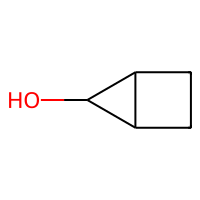

In [34]:
Draw.MolsToImage([m])

In [35]:
print(m.GetAtomWithIdx(1).IsInRingSize(5))

False


More detail about the smallest set of smallest rings (SSSR) is available:

In [40]:
ssr = Chem.GetSymmSSSR(m)
print(ssr)
print(len(ssr))
print(list(ssr[0]))
print(list(ssr[1]))

2
[1, 2, 3]
[4, 5, 2, 3]


2
[1, 2, 3]
[4, 5, 2, 3]


As the name indicates, this is a symmetrized SSSR; if you are interested in the number of “true” SSSR, use the GetSSSR function (note that in this case there’s no difference).

In [41]:
len(Chem.GetSSSR(m))

2

For more efficient queries about a molecule’s ring systems (avoiding repeated calls to `Mol.GetAtomWithIdx`), use the `rdkit.Chem.rdchem.RingInfo` class:

In [45]:
ri = m.GetRingInfo()
print(ri.NumAtomRings(0))  # number of rings that atom 0 is in
print(ri.IsAtomInRingOfSize(1,3))  # is atom 1 in a 3-membered ring?
print(ri.IsBondInRingOfSize(1,3))  # is bond 1 in a 3-membered ring?


0
True
True


### 2.3. Modifying molecules
Normally molecules are stored in the RDKit with the hydrogen atoms implicit (e.g. not explicitly present in the molecular graph. When it is useful to have the hydrogens explicitly present, for example when generating or optimizing the 3D geometry, the `rdkit.Chem.rdmolops.AddHs` function can be used:

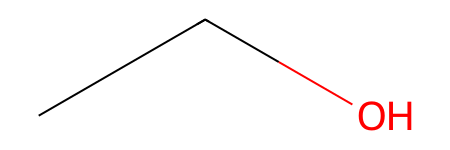

In [46]:
m=Chem.MolFromSmiles('CCO')
m.GetNumAtoms()
m

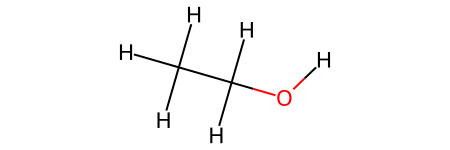

In [47]:
m2 = Chem.AddHs(m)
m2.GetNumAtoms()
m2 

The Hs can be removed again using the `rdkit.Chem.rdmolops.RemoveHs()` function:

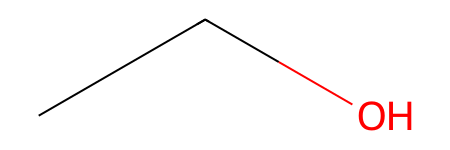

In [48]:
m3 = Chem.RemoveHs(m2)
m3.GetNumAtoms()
m3 

### 2.4. Working with 2D molecules: Generating depictions
The RDKit has a library for generating depictions (sets of 2D) coordinates for molecules. This library, which is part of the `AllChem` module, is accessed using the `rdkit.Chem.rdDepictor.Compute2DCoords()` function. The term "depiction" in this context refers to how the molecules are visually arranged and displayed, rather than just the act of drawing them. 

Note that the 2D conformer is constructed in a canonical orientation and is built to minimize intramolecular clashes, i.e. to maximize the clarity of the drawing. If you have a set of molecules that share a common template and you’d like to align them to that template, you can do so as follows:

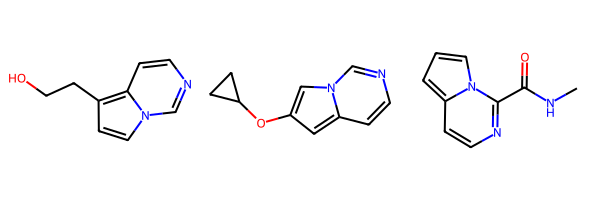

In [56]:
template = Chem.MolFromSmiles('c1nccc2n1ccc2')
AllChem.Compute2DCoords(template)  # Generate 2D coordinates for the template molecule
ms = [Chem.MolFromSmiles(smi) for smi in ('OCCc1ccn2cnccc12','C1CC1Oc1cc2ccncn2c1','CNC(=O)c1nccc2cccn12')]
Chem.Draw.MolsToGridImage(ms)

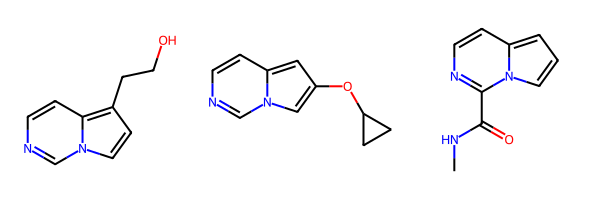

In [57]:
for m in ms:
    _ = AllChem.GenerateDepictionMatching2DStructure(m,template)

Chem.Draw.MolsToGridImage(ms)  # it can be seen that the three molecules are now aligned based on the template.

Another option for Compute2DCoords allows you to generate 2D depictions for molecules that closely mimic 3D conformers. This is available using the function `rdkit.Chem.AllChem.GenerateDepictionMatching3DStructure()`. More fine-grained control can be obtained using the core function `rdkit.Chem.rdDepictor.Compute2DCoordsMimicDistmat()`, but that is beyond the scope of this document. See the implementation of `GenerateDepictionMatching3DStructure` in `AllChem.py` for an example of how it is used.

### 2.5. Working with 3D molecules
The RDKit can generate conformers for molecules using two different methods. The original method used distance geometry. The algorithm followed is:
  - The molecule’s distance bounds matrix is calculated based on the connection table and a set of rules.
  - The bounds matrix is smoothed using a triangle-bounds smoothing algorithm.
  - A random distance matrix that satisfies the bounds matrix is generated.
  - This distance matrix is embedded in 3D dimensions (producing coordinates for each atom).
  - The resulting coordinates are cleaned up somewhat using a crude force field and the bounds matrix.

Note that the conformers that result from this procedure tend to be fairly ugly. They should be cleaned up using a force field. This can be done within the RDKit using its implementation of the Universal Force Field (UFF).

More recently, there is an implementation of the ETKDG method of Riniker and Landrum [18] which uses torsion angle preferences from the Cambridge Structural Database (CSD) to correct the conformers after distance geometry has been used to generate them. With this method, there should be no need to use a minimisation step to clean up the structures.

More detailed information about the conformer generator and the parameters controlling it can be found in the “RDKit Book”. Since the 2018.09 release of the RDKit, ETKDG is the default conformer generation method. Since the 2024.03 release ETKDGv3 is the default. The full process of embedding a molecule is easier than all the above verbiage makes it sound:

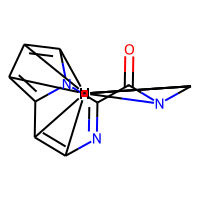

In [61]:
m2=Chem.AddHs(m)
Draw.MolsToImage([m2])  # This will be a 2D depiction of the molecule with hydrogens added.

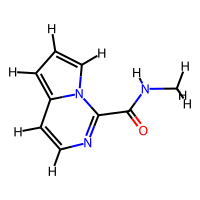

In [64]:
AllChem.EmbedMolecule(m2)
Draw.MolsToImage([m2])  # This will show a 3D depiction of the molecule with hydrogens.

Note that if you re-execute the cell above, you will get a different conformation. This is because the conformer generation is stochastic. If you want to get the same conformer each time, you can set the random seed:

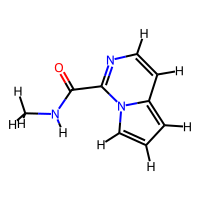

In [65]:
AllChem.EmbedMolecule(m2, randomSeed=0)
Draw.MolsToImage([m2])

The RDKit also has an implementation of the MMFF94 force field available. Please note that the MMFF atom typing code uses its own aromaticity model, so the aromaticity flags of the molecule will be modified after calling MMFF-related methods.

Here’s an example of using MMFF94 to minimize an RDKit-generated conformer:

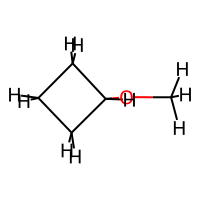

In [66]:
m = Chem.MolFromSmiles('C1CCC1OC')
m2=Chem.AddHs(m)
AllChem.EmbedMolecule(m2)
Draw.MolsToImage([m2])

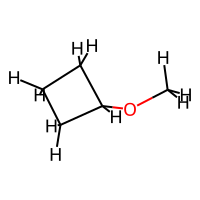

In [69]:
AllChem.MMFFOptimizeMolecule(m2)
Draw.MolsToImage([m2])

Note the calls to `Chem.AddHs()` in the examples above. By default RDKit molecules do not have H atoms explicitly present in the graph, but they are important for getting realistic geometries, so they generally should be added. They can always be removed afterwards if necessary with a call to `Chem.RemoveHs()`.

With the RDKit, multiple conformers can also be generated using the different embedding methods. In both cases this is simply a matter of running the distance geometry calculation multiple times from different random start points. The option `numConfs` allows the user to set the number of conformers that should be generated. Otherwise the procedures are as before. The conformers generated can be aligned to each other and the RMS values calculated.

In [84]:
m = Chem.MolFromSmiles('C1CCC1OC')
m2=Chem.AddHs(m)

# run ETKDG 10 times
cids = AllChem.EmbedMultipleConfs(m2, numConfs=10)  # lend(cids) will be 10

# Calculate the RMS between the conformers
rmslist = []
AllChem.AlignMolConformers(m2, RMSlist=rmslist)
print(rmslist)

[1.065144659752334, 1.1600683467287791, 0.9285016533892141, 1.260313600742849, 0.6696650058593493, 1.4244601710833367, 1.592086863220665, 1.5180615973593232, 1.4009172441408926]


`rmslist` contains the RMS values between the first conformer and all others. The RMS between two specific conformers (e.g. 1 and 9) can also be calculated. The flag `prealigned` lets the user specify if the conformers are already aligned (by default, the function aligns them).

In [86]:
AllChem.GetConformerRMS(m2, 1, 9, prealigned=True)

1.3142586480239762

If you are interested in running MMFF94 on a molecule’s conformers (note that this is often not necessary when using ETKDG), there’s a convenience function available. The result is a list a containing 2-tuples: (`not_converged`, `energy`) for each conformer. If `not_converged` is 0, the minimization for that conformer converged.

In [89]:
AllChem.MMFFOptimizeMoleculeConfs(m2)

[(0, 11.677582322380182),
 (0, 10.728830578551802),
 (0, 10.728830578025546),
 (0, 11.67758232038379),
 (0, 10.7288305773056),
 (0, 11.677582320420774),
 (0, 11.677582321291531),
 (0, 10.728830577592742),
 (0, 10.728830581431975),
 (0, 10.7288305776041)]

By default `AllChem.EmbedMultipleConfs` and `AllChem.MMFFOptimizeMoleculeConfs()` run single threaded, but you can cause them to use multiple threads simultaneously for these embarassingly parallel tasks via the `numThreads` argument. (Setting `numThreads` to zero causes the software to use the maximum number of threads allowed on your computer.)

In [90]:
params = AllChem.ETKDGv3()
params.numThreads = 0
cids = AllChem.EmbedMultipleConfs(m2, 10, params)
res = AllChem.MMFFOptimizeMoleculeConfs(m2, numThreads=0)

Disclaimer/Warning: Conformer generation is a difficult and subtle task. The plain distance-geometry 2D->3D conversion provided with the RDKit is not intended to be a replacement for a “real” conformer analysis tool; it merely provides quick 3D structures for cases when they are required. We believe, however, that the newer ETKDG method is suitable for most purposes.

### 2.6. Preserving molecules
Molecules can be converted to and from text using Python’s pickling machinery:

In [91]:
m = Chem.MolFromSmiles('c1ccncc1')
import pickle
pkl = pickle.dumps(m)
m2=pickle.loads(pkl)
Chem.MolToSmiles(m2)

'c1ccncc1'

The RDKit pickle format is fairly compact and it is much, much faster to build a molecule from a pickle than from a Mol file or SMILES string, so storing molecules you will be working with repeatedly as pickles can be a good idea.

The raw binary data that is encapsulated in a pickle can also be directly obtained from a molecule:

In [94]:
binStr = m.ToBinary()
len(binStr)  # note that this would be shorter than len(pkl)

130

This can be used to reconstruct molecules using the Chem.Mol constructor:

In [95]:
m2 = Chem.Mol(binStr)
Chem.MolToSmiles(m2)

'c1ccncc1'

The small overhead associated with python’s pickling machinery normally doesn’t end up making much of a difference for collections of larger molecules (the extra data associated with the pickle is independent of the size of the molecule, while the binary string increases in length as the molecule gets larger).

Tip: The performance difference associated with storing molecules in a pickled form on disk instead of constantly reparsing an SD file or SMILES table is difficult to overstate. In a test I just ran on my laptop, loading a set of 699 drug-like molecules from an SD file took 10.8 seconds; loading the same molecules from a pickle file took 0.7 seconds. The pickle file is also smaller – 1/3 the size of the SD file – but this difference is not always so dramatic (it’s a particularly fat SD file).

### 2.7. Drawing molecules
We have used some drawing utilities of RDKit above. Here are some more examples.

In [99]:
with Chem.SDMolSupplier('../data/cdk2.sdf') as suppl:
  ms = [x for x in suppl if x is not None]
for m in ms: 
    tmp = AllChem.Compute2DCoords(m)
from rdkit.Chem import Draw
Draw.MolToFile(ms[0],'cdk2_mol1.o.png')    
Draw.MolToFile(ms[1],'cdk2_mol2.o.png')

os.remove('cdk2_mol1.o.png')
os.remove('cdk2_mol2.o.png')

It’s also possible to produce an image grid out of a set of molecules (as we have shown above).

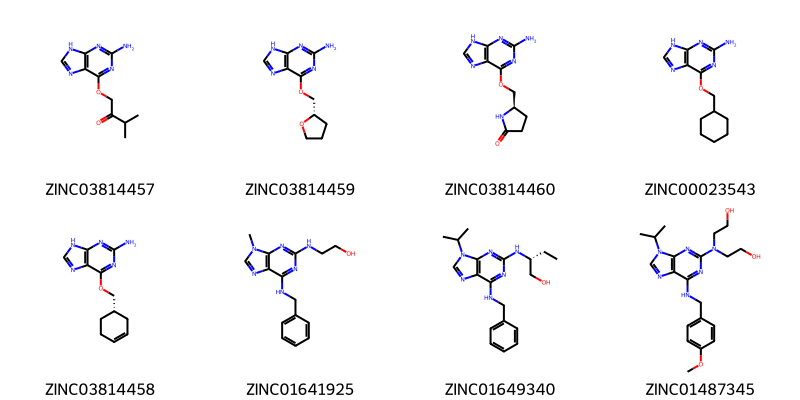

In [115]:
img=Draw.MolsToGridImage(ms[:8], molsPerRow=4, subImgSize=(200,200), legends=[x.GetProp("_Name") for x in ms[:8]])
img

These would of course look better if the common core were aligned. This is easy enough to do. (Note that `ms` has 47 entries, and 14 of them has the substructure/template specified below.)

47
14


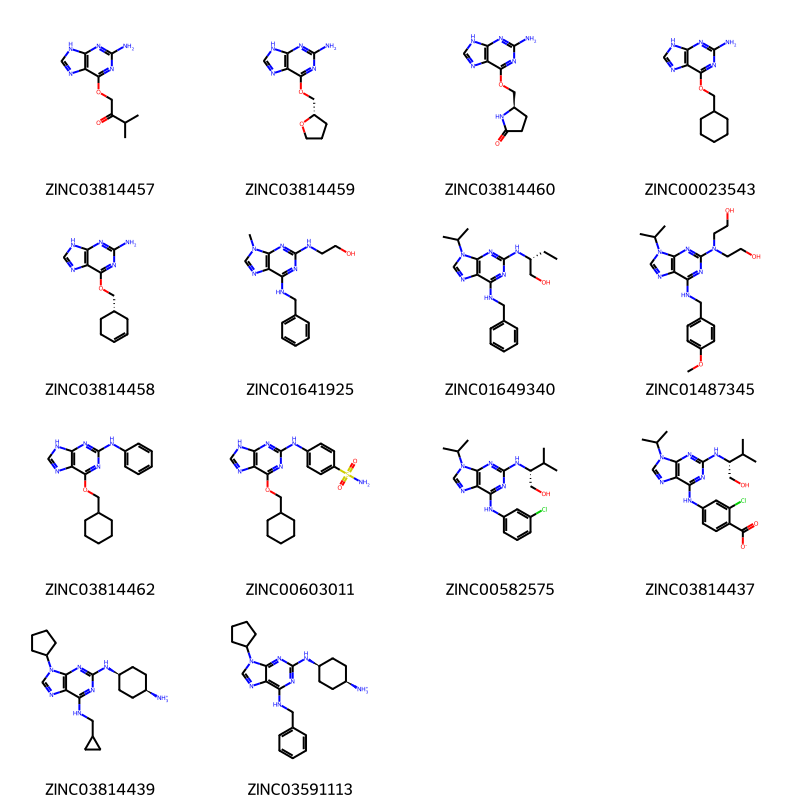

In [117]:
p = Chem.MolFromSmiles('[nH]1cnc2cncnc21')
subms = [x for x in ms if x.HasSubstructMatch(p)]
AllChem.Compute2DCoords(p)

print(len(ms))
print(len(subms))

for m in subms:
  _ = AllChem.GenerateDepictionMatching2DStructure(m, p)
Draw.MolsToGridImage(subms, molsPerRow=4, subImgSize=(200,200), legends=[x.GetProp("_Name") for x in subms])

Atoms in a molecule can be highlighted by drawing a coloured solid or open circle around them, and bonds likewise can have a coloured outline applied. An obvious use is to show atoms and bonds that have matched a substructure query.

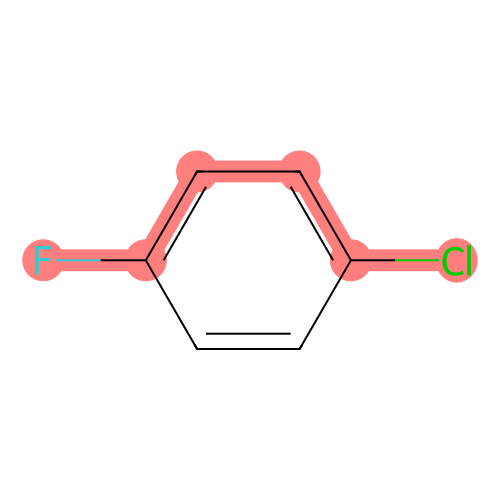

In [134]:
from rdkit.Chem.Draw import rdMolDraw2D

smi = 'c1cc(F)ccc1Cl'
mol = Chem.MolFromSmiles(smi)
patt = Chem.MolFromSmarts('ClccccF')
hit_ats = list(mol.GetSubstructMatch(patt))
hit_bonds = []
for bond in patt.GetBonds():
   aid1 = hit_ats[bond.GetBeginAtomIdx()]
   aid2 = hit_ats[bond.GetEndAtomIdx()]
   hit_bonds.append(mol.GetBondBetweenAtoms(aid1,aid2).GetIdx())
   
d = rdMolDraw2D.MolDraw2DSVG(500, 500) # or MolDraw2DCairo to get PNGs
rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=hit_ats, highlightBonds=hit_bonds)

# Below we display the image
d.FinishDrawing()  # This means that the molecule is ready for display
svg = d.GetDrawingText()

from IPython.display import SVG
SVG(svg)

It is possible to specify the colours for individual atoms and bonds:

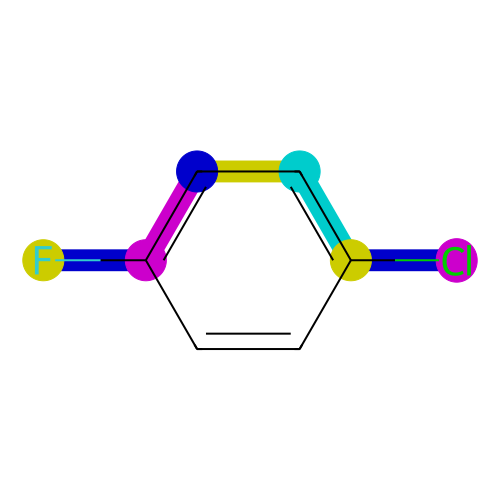

In [136]:
colours = [(0.8,0.0,0.8),(0.8,0.8,0),(0,0.8,0.8),(0,0,0.8)]
atom_cols = {}
for i, at in enumerate(hit_ats):
    atom_cols[at] = colours[i%4]
bond_cols = {}
for i, bd in enumerate(hit_bonds):
    bond_cols[bd] = colours[3 - i%4]

d = rdMolDraw2D.MolDraw2DCairo(500, 500)
rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=hit_ats,
                                   highlightAtomColors=atom_cols,
                                   highlightBonds=hit_bonds,
                                   highlightBondColors=bond_cols)
d.FinishDrawing()

# Below we display the image
from IPython.display import Image
Image(d.GetDrawingText())

Atoms and bonds can also be highlighted with multiple colours if they fall into multiple sets, for example if they are matched by more than 1 substructure pattern. This is too complicated to show in this simple introduction, but there is an example in `data/test_multi_colours.py`. 

As of version 2020.03, it is possible to add arbitrary small strings to annotate atoms and bonds in the drawing. The strings are added as properties `atomNote` and `bondNote` and they will be placed automatically close to the atom or bond in question in a manner intended to minimise their clash with the rest of the drawing. For convenience, here are 3 flags in `MolDraw2DOptions` that will add stereo information (R/S to atoms, E/Z to bonds) and atom and bond sequence numbers.

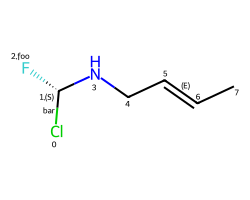

In [138]:
mol = Chem.MolFromSmiles(r'Cl[C@H](F)NC\C=C\C')
d = rdMolDraw2D.MolDraw2DCairo(250, 200) # or MolDraw2DSVG to get SVGs
mol.GetAtomWithIdx(2).SetProp('atomNote', 'foo')
mol.GetBondWithIdx(0).SetProp('bondNote', 'bar')
d.drawOptions().addStereoAnnotation = True
d.drawOptions().addAtomIndices = True
d.DrawMolecule(mol)
d.FinishDrawing()

Image(d.GetDrawingText())

# Below we can save the iamge
# d.WriteDrawingText('atom_annotation_1.png')   

Since the `atomLabel` property is also used for other things (for example in CXSMILES as demonstrated), if you want to provide your own atom labels, it’s better to use the `_displayLabel` property:

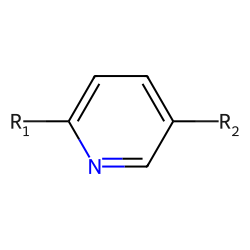

In [139]:
smi = 'c1nc(*)ccc1* |$;;;R1;;;;R2$|'
mol = Chem.MolFromSmiles(smi)
mol.GetAtomWithIdx(3).SetProp("_displayLabel","R<sub>1</sub>")
mol.GetAtomWithIdx(7).SetProp("_displayLabel","R<sub>2</sub>")
d = rdMolDraw2D.MolDraw2DCairo(250, 250)
rdMolDraw2D.PrepareAndDrawMolecule(d,mol)
d.FinishDrawing()
Image(d.GetDrawingText())

Note that you can use `<sup>` and `<sub>` in these labels to provide super- and subscripts.

Finally, if you have atom labels which should be displayed differently when the bond comes into them from the right (the West), you can also set the `_displayLabelW` property:

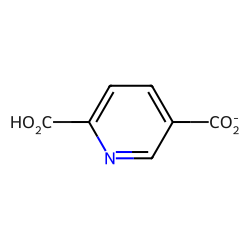

In [140]:
smi = 'c1nc(*)ccc1* |$;;;R1;;;;R2$|'
mol = Chem.MolFromSmiles(smi)
mol.GetAtomWithIdx(3).SetProp("_displayLabel","CO<sub>2</sub>H")
mol.GetAtomWithIdx(3).SetProp("_displayLabelW","HO<sub>2</sub>C")
mol.GetAtomWithIdx(7).SetProp("_displayLabel","CO<sub>2</sub><sup>-</sup>")
mol.GetAtomWithIdx(7).SetProp("_displayLabelW","<sup>-</sup>OOC")
d = rdMolDraw2D.MolDraw2DCairo(250, 250)
rdMolDraw2D.PrepareAndDrawMolecule(d,mol)
d.FinishDrawing()
Image(d.GetDrawingText()) 

### 2.8. Metadata in molecule images
The PNG files generated by the `MolDraw2DCairo` class by default include metadata about the molecule(s) or chemical reaction included in the drawing. This metadata can be used later to reconstruct the molecule(s) or reaction. The molecular metadata is stored using standard metadata tags in the PNG and is, of course, not visible when you look at the PNG.

In [144]:
template = Chem.MolFromSmiles('c1nccc2n1ccc2')
AllChem.Compute2DCoords(template)

ms = [Chem.MolFromSmiles(smi) for smi in ('OCCc1ccn2cnccc12','C1CC1Oc1cc2ccncn2c1','CNC(=O)c1nccc2cccn12')]
_ = [AllChem.GenerateDepictionMatching2DStructure(m, template) for m in ms]
d = rdMolDraw2D.MolDraw2DCairo(250, 200)
d.DrawMolecule(ms[0])
d.FinishDrawing()
png = d.GetDrawingText()
mol = Chem.MolFromPNGString(png)
Chem.MolToSmiles(mol)

<class 'bytes'>


'OCCc1c2ccncn2cc1'

If the PNG contains multiple molecules we can retrieve them all at once using `Chem.MolsFromPNGString()`:
```
png = Draw.MolsToGridImage(ms, returnPNG=True)
print(type(png))
mols = Chem.MolsFromPNGString(png)
for mol in mols:
    print(Chem.MolToSmiles(mol))
```
Well, actually the code block above would give the following error:
```
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
Cell In[145], line 3
      1 png = Draw.MolsToGridImage(ms, returnPNG=True)
      2 print(type(png))
----> 3 mols = Chem.MolsFromPNGString(png)
      4 for mol in mols:
      5     print(Chem.MolToSmiles(mol))

TypeError: No registered converter was able to produce a C++ rvalue of type std::__1::basic_string<wchar_t, std::__1::char_traits<wchar_t>, std::__1::allocator<wchar_t> > from this Python object of type Image
```
There might have been a bug in the option `returnPNG` in `Draw.MolsToGridImage()`.

## 3. Substructure searching

### 3.1. Stereochemistry in substructure matches

### 3.2. Atom map indices in SMARTS

### 3.3. Advanced substructure matching

### 3.4. Advanced substructure matching

## 4. Chemical transformations

### 4.1. Substructure-based transformations

### 4.2. Murcko decomposition

## 5. Maximum common substructure

### 5.1. FindMCS

### 5.2. RascalMCES

### 5.3. Clustering with Rascal

## 6. Fingerprinting and molecular similarity

### 6.1. RDKit (topological) fingerprints

### 6.2. Atom pairs and topological torsions

### 6.3. Morgan fingerprints (circular fingerprints)

### 6.4. MACCS keys

### 6.5. Explaining bits from fingerprints

#### 6.5.1. Morgan fingerprints

#### 6.5.2. RDKit fingerprints

### 6.6. Generating images of fingerprint bits

### 6.7. Picking diverse molecules using fingerprints

### 6.8. Generating similarity maps using fingerprints

## 7. Descriptor calculation

### 7.1. Calculating all descriptors

### 7.2. calculating partial charges

### 7.3. Visualization of descriptors

## 8. Chemical features and pharmacophores

### 8.1. Chemical features

### 8.2. 2D pharmacophore fingerprints

## 9. Molecular fragments

## 10. Getting help

## 11. Advanced topics/warnings

## 12. Filtering molecular datasets

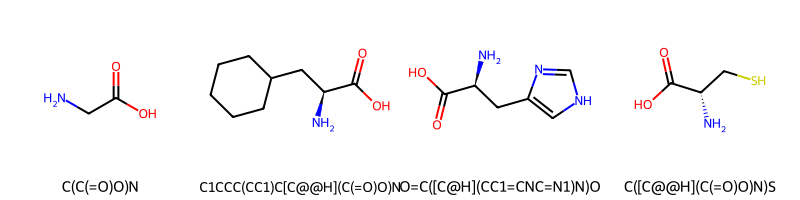

In [23]:
# smiles strings of glycine, phenylalanine, histidine, and cysteine
smiles_list = [
    'C(C(=O)O)N', 
    'C1CCC(CC1)C[C@@H](C(=O)O)N',
    'O=C([C@H](CC1=CNC=N1)N)O',
    'C([C@@H](C(=O)O)N)S'
]

mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
img = Draw.MolsToGridImage(mol_list, molsPerRow=4, legends=smiles_list)
img

In [24]:
pattern_1 = Chem.MolFromSmiles('C(=O)O')  # carboxyl group
pattern_2 = Chem.MolFromSmiles('S')
pattern_3 = Chem.MolFromSmarts('[r5]')  # SMARTS string for a five-membered ring

import prettytable as pt
table = pt.PrettyTable()
table.field_names = ['Pattern', 'Glycine', 'Phenylalanine', 'Histidine', 'Cysteine']
table.add_row(['Carboxyl group'] + [mol.HasSubstructMatch(pattern_1) for mol in mol_list])
table.add_row(['Sulfur'] + [mol.HasSubstructMatch(pattern_2) for mol in mol_list])
table.add_row(['Five-membered ring'] + [mol.HasSubstructMatch(pattern_3) for mol in mol_list])
print(table)

+--------------------+---------+---------------+-----------+----------+
|      Pattern       | Glycine | Phenylalanine | Histidine | Cysteine |
+--------------------+---------+---------------+-----------+----------+
|   Carboxyl group   |   True  |      True     |    True   |   True   |
|       Sulfur       |  False  |     False     |   False   |   True   |
| Five-membered ring |  False  |     False     |    True   |  False   |
+--------------------+---------+---------------+-----------+----------+


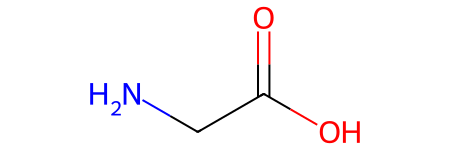

In [25]:
glycine = mol_list[0]
glycine

In [26]:
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect(glycine, 2, nBits=1024, bitInfo=bi)
fp_arr = numpy.zeros((1,))
DataStructs.ConvertToNumpyArray(fp, fp_arr)
print(fp_arr)
print(np.nonzero(fp_arr))

NameError: name 'numpy' is not defined

In [ ]:
prints = [(glycine, x, bi) for x in fp.GetOnBits()]
prints

[(<rdkit.Chem.rdchem.Mol at 0x7fc7cd057820>,
  27,
  {27: ((0, 1),),
   80: ((0, 0),),
   147: ((4, 0),),
   389: ((3, 1),),
   650: ((2, 0),),
   713: ((1, 1),),
   807: ((1, 0), (3, 0)),
   893: ((2, 1),),
   966: ((0, 2),),
   981: ((4, 1),)}),
 (<rdkit.Chem.rdchem.Mol at 0x7fc7cd057820>,
  80,
  {27: ((0, 1),),
   80: ((0, 0),),
   147: ((4, 0),),
   389: ((3, 1),),
   650: ((2, 0),),
   713: ((1, 1),),
   807: ((1, 0), (3, 0)),
   893: ((2, 1),),
   966: ((0, 2),),
   981: ((4, 1),)}),
 (<rdkit.Chem.rdchem.Mol at 0x7fc7cd057820>,
  147,
  {27: ((0, 1),),
   80: ((0, 0),),
   147: ((4, 0),),
   389: ((3, 1),),
   650: ((2, 0),),
   713: ((1, 1),),
   807: ((1, 0), (3, 0)),
   893: ((2, 1),),
   966: ((0, 2),),
   981: ((4, 1),)}),
 (<rdkit.Chem.rdchem.Mol at 0x7fc7cd057820>,
  389,
  {27: ((0, 1),),
   80: ((0, 0),),
   147: ((4, 0),),
   389: ((3, 1),),
   650: ((2, 0),),
   713: ((1, 1),),
   807: ((1, 0), (3, 0)),
   893: ((2, 1),),
   966: ((0, 2),),
   981: ((4, 1),)}),
 (<rdk

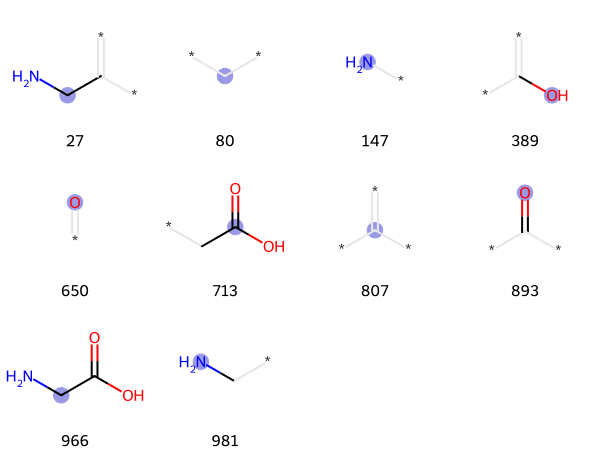

In [ ]:
# Below are 10 substructure patterns that are present in glycine
Draw.DrawMorganBits(prints, molsPerRow=4, legends=[str(x) for x in fp.GetOnBits()])

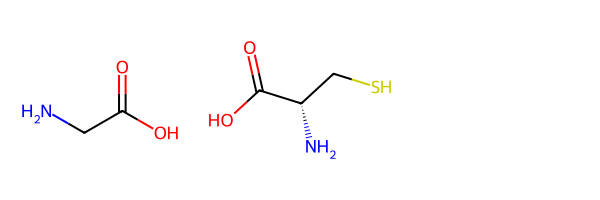

In [ ]:
cysteine = mol_list[3]
img = Draw.MolsToGridImage([glycine, cysteine])
img

In [ ]:
fp2 = AllChem.GetMorganFingerprintAsBitVect(cysteine, 2, nBits=1024, bitInfo=bi)
print('gly', list(fp.GetOnBits()))
print('cys', list(fp2.GetOnBits()))

common = set(fp.GetOnBits()) & set(fp2.GetOnBits())
combined = set(fp.GetOnBits()) | set(fp2.GetOnBits())
print('common', len(common))
print('combined', len(combined))
print('Tanimoto similarity', len(common) / len(combined))
print(DataStructs.TanimotoSimilarity(fp, fp2))

gly [27, 80, 147, 389, 650, 713, 807, 893, 966, 981]
cys [1, 48, 80, 147, 229, 321, 389, 403, 435, 650, 786, 807, 820, 825, 893, 902]
common 6
combined 20
Tanimoto similarity 0.3
0.3
